In [2508]:
import pandas as pd
# df = pd.read_pickle("twitts")
df = pd.read_pickle("try")
# df = pd.read_pickle("500")
df.index = [i for i in range(len(df))]

In [2509]:
df.shape

(2800, 4)

In [2510]:
df.tail()

,screen_name,date_time,location,text
2795,TMobileHelp,2021-04-17 21:12:00,"Bellevue, WA",@RussellWolff Hi Russel! Having an accurate bi...
2796,ShieldVoC,2021-04-17 21:11:48,"Stockholm, Sweden",RT @RussellWolff: @TMobile @TMobileHelp NEED H...
2797,TMobileHelp,2021-04-17 21:10:44,"Bellevue, WA","@NoMayflower Hey Amri, this doesn't sound righ..."
2798,RussellWolff,2021-04-17 21:10:09,"Los Angeles, CA",@TMobile @TMobileHelp NEED HELP ASAP! You over...
2799,TMobileHelp,2021-04-17 21:08:52,"Bellevue, WA","@ZoeyHatesTrump @NevilleRay Hey Joyce, this is..."



### Pre-processing tweets

Провести обработку текста:

    -удалить стоп-слова 0
    -найти обращения по @ или хэштеги
    -найти ссылки на сайты
    -разбить по словам и n-граммы


In [2511]:
# чистим текст сообщений, делаем preprocessing

import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import time

start_time = time.time() 

tokenizer = TweetTokenizer()
tokenized_tweets = [tokenizer.tokenize(t) for t in df.text]

stop_words = stopwords.words("english")
stop_words.extend(["&amp;", "&gt;", "&lt;"])
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

clean_text = []
handles = []
hashtags = []
carrier = []
links = []
# простой пример pre-processing
for tweet in tokenized_tweets:

    thandles = []
    thashtags = []
    joined_words = " "
    words = [w.lower() for w in tweet if len(w)>2 and w not in stop_words]
    thandles = [w for w in words if re.search("^@\w+", w)]
    tlinks = [w for w in words if re.search("^https:\w+", w)]
#     print(tlinks)
    thashtags = [w for w in words if re.search("^#\w+", w)]
    words = [w for w in words if w.isalpha() and w not in thandles and w not in thashtags and w not in tlinks]
    words = [lemmatizer.lemmatize(w) for w in words]
    
    joined_words = joined_words.join(words)
    tlength = len(joined_words)
    handles.append(thandles)
    hashtags.append(thashtags)
    links.append(tlinks)
    clean_text.append(joined_words)

In [2512]:
df['clean_text'] = clean_text
df['handles'] = handles
df['hashtags'] = hashtags
df['links'] = links
df.head()

,screen_name,date_time,location,text,clean_text,handles,hashtags,links
0,ShieldVoC,2021-04-14 23:57:51,"Stockholm, Sweden",RT @europabridge1: @VerizonSupport will someon...,someone please explain setting called turned p...,"[@europabridge1, @verizonsupport]",[],[]
1,ShieldVoC,2021-04-14 23:56:27,"Stockholm, Sweden",RT @halidkalkan: @Verizon trying to charge me ...,trying charge device never solve problem canno,"[@halidkalkan, @verizon, @afni, @ups]",[],[]
2,VerizonSupport,2021-04-14 23:43:51,,@MushShoe Thanks for confirming. We can assist...,thanks confirming assist plan change well happ...,[@mushshoe],[],[]
3,MushShoe,2021-04-14 23:39:05,,"@VerizonSupport Want pricing, my plan ends 3 d...",want pricing plan end day till plan end today ...,[@verizonsupport],[],[]
4,VerizonSupport,2021-04-14 23:34:05,,@MushShoe Sorry for your trouble. We are also ...,sorry trouble also able provide assistance are...,[@mushshoe],[],[]


In [2513]:
# n-grams
# import nltk
# # nltk.download('wordnet')
# from nltk import ngrams
# import collections as c
# all_grams = []
# for string in df.text:
#     gram_2 = []
#     for i in ngrams(string.split(),2):
# #         print(i)
#         gram_2.append(i)
#     all_grams.append(gram_2)
# df['all_grams'] = all_grams
# df.head()

### Разработка сегментов

### Вопрос 1. - какие еще могут быть сегменты?

*Добавил субъективность

https://core.ac.uk/download/pdf/82425196.pdf

In [2514]:
# pip install textblob

In [2515]:
# добавляем polarity и subjectivity

# изучить textblob
# https://textblob.readthedocs.io/en/dev/

from textblob import TextBlob
polarity = [0.0]*len(df)
subjectivity = [0.5]*len(df)
sentiment = [""]*len(df)
fact = [""]*len(df)
for i in df.index:
#     print(df.clean_text[i])
    blob = TextBlob(str(df.clean_text[i]))
    polarity[i] = blob.polarity
    subjectivity[i] = blob.subjectivity
    
#     # разбивки на сегменты 
#     # а какие способы ты знаешь ещё?
    if polarity[i] > 0.0:
        sentiment[i] = "pos"
    elif polarity[i] < 0.0:
        sentiment[i] = "neg"
    else:
        sentiment[i] = "neu"
        
    if subjectivity[i] > 0.5:
        fact[i] = 0
    else:
        fact[i] = 1
    
df["sentiment"]    = sentiment
df["polarity"]     = polarity
df["subjectivity"] = subjectivity
df['fact'] = fact

### Вопрос 2. - нужен ли emoji analysis???

  -https://pypi.org/project/emosent-py/
  
  -https://github.com/ajinkyachavan/Emoticon-Based-Sentiment-Analysis-Python/blob/master/emoticon-based-sentiment-analysis-of-twitter-data.pdf

In [2516]:
# проработать emoji - отражают возраст

# emoji = []
# for i in df.text:
#     emo = re.findall(r'[^\w\s,-@\'\^…’!#$)(+*“&”~|%]',i)
#     emoji.append(emo)
# df['emoji'] = emoji


### Сделаем разбивку по операторам



###  Вопрос 3. В чем смысл этой функции, если мы загружали данные через tweepy  изначально по операторам?

In [2517]:
# создадим колонку, которая укажет, какой это оператор

# def carrier(df,name):
#     carrier = []

#     for text in df[['screen_name','text']].values:
#         screen_name = text[0].lower()
#         twitter_text = text[1].lower()
#         current_carrier = []
#         if name.lower() in twitter_text or name.lower() in screen_name:
#             current_carrier.append(name)

#         ... 
#         carrier.append(' '.join(current_carrier))
#     df['carrier'] = carrier
#     return df



In [2518]:
carrier = []
def carrier (df,name):
    for text in df[['screen_name','text']].values:
        screen_name = text[0].lower()
        twitter_text = text[1].lower()
        current_carrier = []
        if name.lower() in twitter_text or name.lower() in screen_name:
            df.loc[df[df['text'] == text[1]].index,'carrier'] = name.lower()
    return df

# df = carrier(df,'VZWSupport')
# df.head()

In [2519]:
# добавляяем колонку "оператор"

car = ['verizon','VerizonSupport','VZWSupport','ATT','ATTHelp','TMobile','TMobileHelp']
for i in car:
    df = carrier(df,i)
#     print(df['carrier'].unique())

###  Вопрос 4.зачем эта часть кода - токенайзер делали выше?

In [2520]:
# сделай какой-нибудь токинайзер
# https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BA%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7
# https://docs.python.org/3/library/tokenize.html

# tokenized_tweets = [tokenizer.tokenize(t) for t in df.text]
# clf_text = []
# for tweet in tokenized_tweets:
#     joined_words = " "
#     words = [w.lower() for w in tweet if w.isalpha() or w[0]=='@']
#     tlinks = [w for w in words if re.search("^https:\w+", w)]
#     words = [w for w in words if  w not in tlinks]
#     joined_words = joined_words.join(words)
#     clf_text.append(joined_words)

# df["clf_text"] = clf_text

### Сделай обзор по группам (EDA)

In [2521]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [2522]:
clean_df = df[~df['carrier'].isna()][['screen_name','carrier','location','date_time','text','clean_text','polarity','sentiment','fact']]
clean_df

,screen_name,carrier,location,date_time,text,clean_text,polarity,sentiment,fact
0,ShieldVoC,verizonsupport,"Stockholm, Sweden",2021-04-14 23:57:51,RT @europabridge1: @VerizonSupport will someon...,someone please explain setting called turned p...,0.000000,neu,1
1,ShieldVoC,verizon,"Stockholm, Sweden",2021-04-14 23:56:27,RT @halidkalkan: @Verizon trying to charge me ...,trying charge device never solve problem canno,0.000000,neu,1
2,VerizonSupport,verizonsupport,,2021-04-14 23:43:51,@MushShoe Thanks for confirming. We can assist...,thanks confirming assist plan change well happ...,0.500000,pos,0
3,MushShoe,verizonsupport,,2021-04-14 23:39:05,"@VerizonSupport Want pricing, my plan ends 3 d...",want pricing plan end day till plan end today ...,0.000000,neu,1
4,VerizonSupport,verizonsupport,,2021-04-14 23:34:05,@MushShoe Sorry for your trouble. We are also ...,sorry trouble also able provide assistance are...,-0.066667,neg,0
...,...,...,...,...,...,...,...,...,...
2795,TMobileHelp,tmobilehelp,"Bellevue, WA",2021-04-17 21:12:00,@RussellWolff Hi Russel! Having an accurate bi...,russel having accurate bill love help please c...,0.450000,pos,0
2796,ShieldVoC,tmobilehelp,"Stockholm, Sweden",2021-04-17 21:11:48,RT @RussellWolff: @TMobile @TMobileHelp NEED H...,need help asap you overcharged current bill no...,0.200000,pos,0
2797,TMobileHelp,tmobilehelp,"Bellevue, WA",2021-04-17 21:10:44,"@NoMayflower Hey Amri, this doesn't sound righ...",hey amri sound right would love help whenever ...,0.546429,pos,1
2798,RussellWolff,tmobilehelp,"Los Angeles, CA",2021-04-17 21:10:09,@TMobile @TMobileHelp NEED HELP ASAP! You over...,need help asap you overcharged current bill no...,0.000000,neu,1


In [2523]:
# добавим месяц,час,dummy-переменную sentiment и длину текстового сообщения

import datetime as dt
# clean_df['month'] = clean_df['date_time'].dt.month
clean_df['hour'] = clean_df['date_time'].dt.hour
clean_df['sense_dummy'] = clean_df['sentiment'].apply(lambda x: 1 if x == 'pos' else (0 if x == 'neu' else -1))
clean_df['text_len'] = clean_df['clean_text'].apply(lambda x:len(x))
clean_df.drop('sentiment',inplace = True,axis = 1)
# clean_df['len_emoji'] = clean_df['emoji'].apply(lambda x:len(x))
clean_df['day'] = df['date_time'].dt.weekday
clean_df.head(3)

,screen_name,carrier,location,date_time,text,clean_text,polarity,fact,hour,sense_dummy,text_len,day
0,ShieldVoC,verizonsupport,"Stockholm, Sweden",2021-04-14 23:57:51,RT @europabridge1: @VerizonSupport will someon...,someone please explain setting called turned p...,0.0,1,23,0,54,2
1,ShieldVoC,verizon,"Stockholm, Sweden",2021-04-14 23:56:27,RT @halidkalkan: @Verizon trying to charge me ...,trying charge device never solve problem canno,0.0,1,23,0,46,2
2,VerizonSupport,verizonsupport,,2021-04-14 23:43:51,@MushShoe Thanks for confirming. We can assist...,thanks confirming assist plan change well happ...,0.5,0,23,1,54,2


In [2524]:
clean_df.describe()


,polarity,fact,hour,sense_dummy,text_len,day
count,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000
mean,0.116633,0.699140,21.645927,0.284486,46.090463,3.542775
std,0.307696,0.458726,1.922828,0.683634,20.365146,1.120920
min,-1.000000,0.000000,11.000000,-1.000000,0.000000,2.000000
25%,0.000000,0.000000,21.000000,0.000000,31.000000,3.000000
50%,0.000000,1.000000,22.000000,0.000000,49.000000,4.000000
75%,0.250000,1.000000,23.000000,1.000000,61.000000,5.000000
max,1.000000,1.000000,23.000000,1.000000,98.000000,5.000000


In [2525]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2443 entries, 0 to 2799
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   screen_name  2443 non-null   object        
 1   carrier      2443 non-null   object        
 2   location     2443 non-null   object        
 3   date_time    2443 non-null   datetime64[ns]
 4   text         2443 non-null   object        
 5   clean_text   2443 non-null   object        
 6   polarity     2443 non-null   float64       
 7   fact         2443 non-null   int64         
 8   hour         2443 non-null   int64         
 9   sense_dummy  2443 non-null   int64         
 10  text_len     2443 non-null   int64         
 11  day          2443 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 248.1+ KB


In [2526]:
clean_df.head(3)

,screen_name,carrier,location,date_time,text,clean_text,polarity,fact,hour,sense_dummy,text_len,day
0,ShieldVoC,verizonsupport,"Stockholm, Sweden",2021-04-14 23:57:51,RT @europabridge1: @VerizonSupport will someon...,someone please explain setting called turned p...,0.0,1,23,0,54,2
1,ShieldVoC,verizon,"Stockholm, Sweden",2021-04-14 23:56:27,RT @halidkalkan: @Verizon trying to charge me ...,trying charge device never solve problem canno,0.0,1,23,0,46,2
2,VerizonSupport,verizonsupport,,2021-04-14 23:43:51,@MushShoe Thanks for confirming. We can assist...,thanks confirming assist plan change well happ...,0.5,0,23,1,54,2


In [2527]:
# описание по среднему и count
polarity_by_carrier = clean_df.groupby('carrier').agg('mean').sort_values(by = 'polarity',ascending = False)
polarity_by_carrier

,polarity,fact,hour,sense_dummy,text_len,day
carrier,,,,,,
tmobilehelp,0.233893,0.581454,21.887218,0.513784,47.240602,3.533835
tmobile,0.135620,0.753894,22.813084,0.401869,45.794393,3.470405
vzwsupport,0.133399,0.612403,21.545220,0.335917,50.183463,3.506460
verizonsupport,0.108357,0.656510,19.429363,0.210526,46.216066,3.520776
att,0.072565,0.810559,22.810559,0.124224,37.593168,3.552795
verizon,0.055208,0.691700,22.889328,0.169960,41.411067,3.758893
atthelp,0.050001,0.810000,20.842500,0.180000,50.907500,3.520000


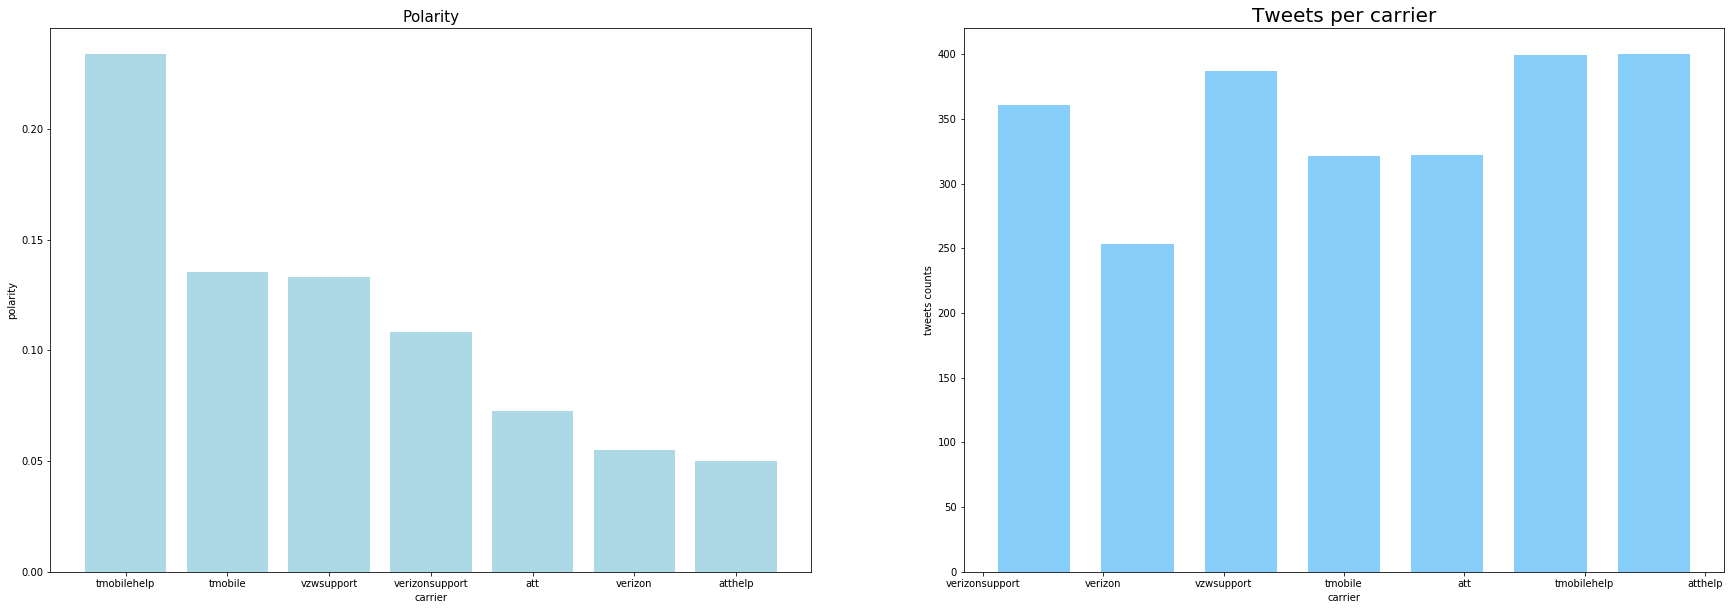

In [2528]:
# описательная статистика по polarity и количеству твиттов

plt.figure(figsize=(30,10))
plt.subplot(121)
plt.bar(polarity_by_carrier.index,polarity_by_carrier['polarity'],color='lightblue')
plt.title('Sentiments polarity per carrier', fontsize=15)
plt.xlabel('carrier')
plt.ylabel('polarity')
plt.title('Polarity', fontsize=15)


# распределение количества операторов в дф
plt.subplot(122)
plt.hist(clean_df['carrier'],align = 'mid',rwidth=0.7,color = 'lightskyblue',histtype = 'bar',bins = 7)
plt.xlabel('carrier')
plt.ylabel('tweets counts')
plt.title('Tweets per carrier', fontsize=20)
plt.show()

In [2529]:
# распределение по сентиментам
clean_df.groupby('sense_dummy')['carrier'].agg('count')

sense_dummy
-1     322
 0    1104
 1    1017
Name: carrier, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018ADE6EC788>,
      dtype=object)

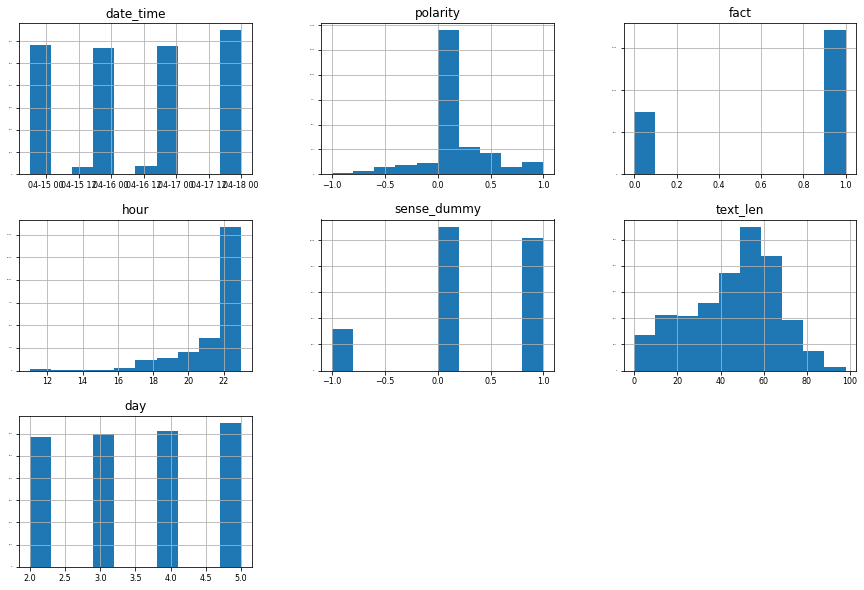

In [2530]:
# распределение всех числовых фичей

clean_df.hist(figsize=(15, 10), bins=10, xlabelsize=8, ylabelsize=2)

In [2531]:
# боксплот по длине слов в корпусе
# sns.boxplot(clean_df['text_len'])

In [2532]:
# heatmap - с лекции по numpy
# выделение столбцов для heatmap корреляции
# cor_col=['fact','month','hour','text_len','len_emoji','day']
# target = clean_df['sense_dummy']

# def plot_correlation_map( df ):
#     corr = df.corr()
#     _ , ax = plt.subplots( figsize =( 12 , 10 ) )
#     cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
#     _ = sns.heatmap(
#         corr, 
#         cmap = cmap,
#         square=True, 
#         cbar_kws={ 'shrink' : .9 }, 
#         ax=ax, 
#         annot = True, 
#         annot_kws = { 'fontsize' : 12 }
#     )
# plot_correlation_map( clean_df )

### Определи, какие слова наиболее характерны для операторов

  * какие cлова чаще, чем остальные встречаются для определенного оператора

In [2533]:
# функция подсчета слов для оператора

from collections import Counter


# car = 'VerizonSupport'
# carrier_corpus = []
# for t  in clean_df[clean_df['carrier']== car]['clean_text']:
#     for j in t.split():
#         carrier_corpus.append(j)
        
# total_term_frequency = Counter(carrier_corpus)
# for word, freq in total_term_frequency.most_common(10):
#     word_dist = {}
#     word_dist[word] = freq
# #     print("{}\t{}".format(word, freq))
#     plt.bar(word_dist.keys(), word_dist.values(), color='g')
# car = 'VerizonSupport'
def word_frequency_bar(clean_df,carrier_name):
    carrier_corpus = []
    for t  in clean_df[clean_df['carrier']== carrier_name]['clean_text']:
        for j in t.split():
            carrier_corpus.append(j)

    total_term_frequency = Counter(carrier_corpus)
    word_dist = {}
    for word, freq in total_term_frequency.most_common(10):
        word_dist[word] = freq
#         print ("{}\t{}".format(word, freq))
        plt.bar(word_dist.keys(), word_dist.values(), color='b')

# word_frequency_bar(clean_df,car)


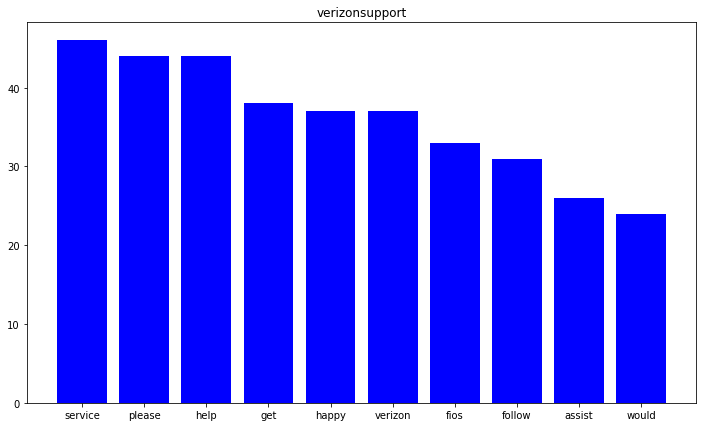

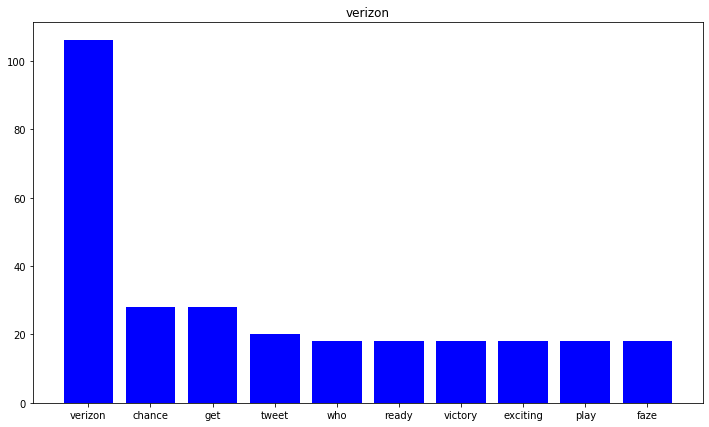

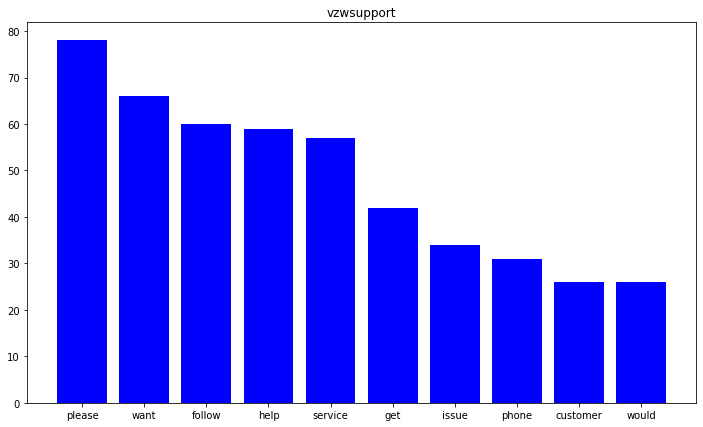

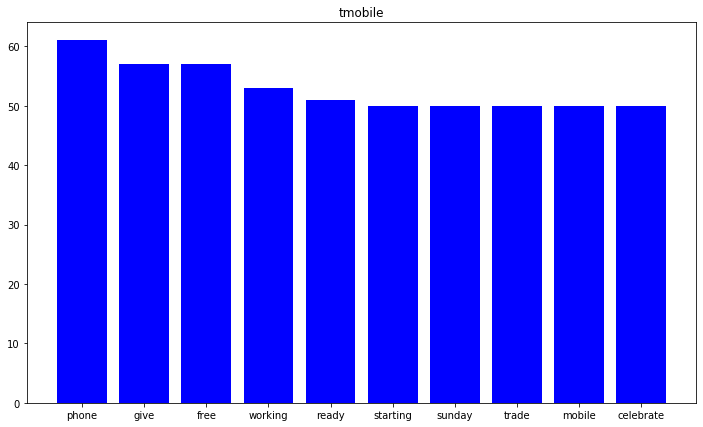

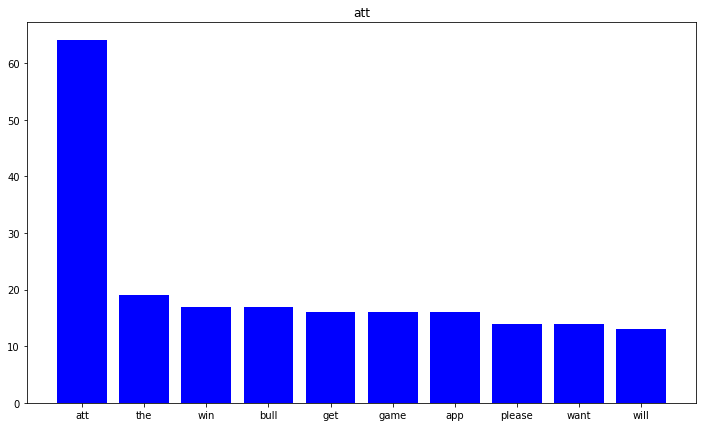

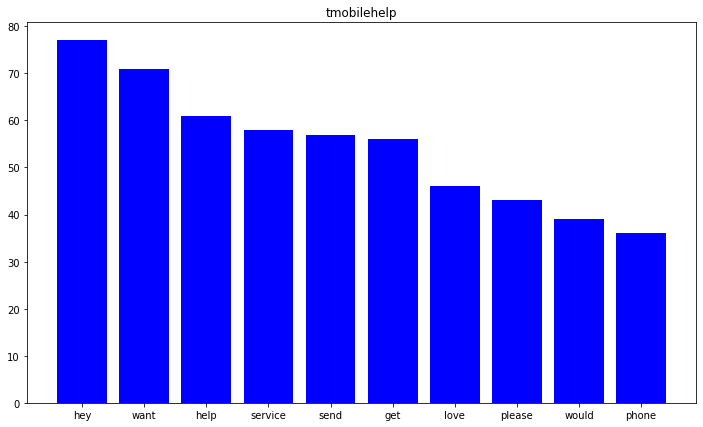

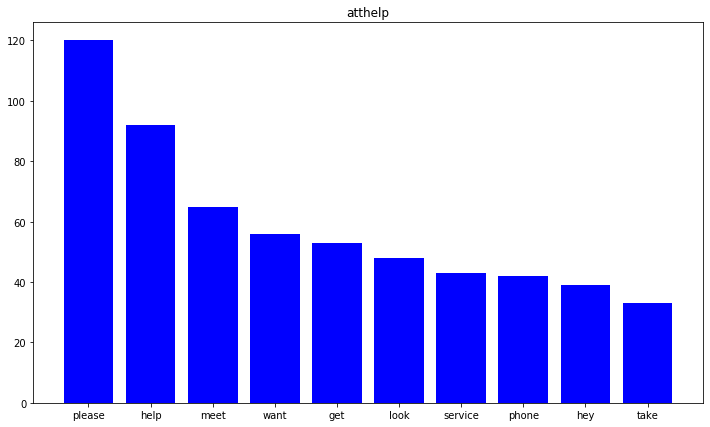

In [2534]:
# графики распределения слов для каждого оператора

# fig, axs = plt.subplots(len(clean_df['carrier'].unique()), 1, figsize=(12, 7))
for i in clean_df['carrier'].unique():
    fig, axs = plt.subplots(1, 1, figsize=(12, 7))
    word_frequency_bar(clean_df,i)
    plt.title(i)

* посмотреть распределения по словам, относительно операторов

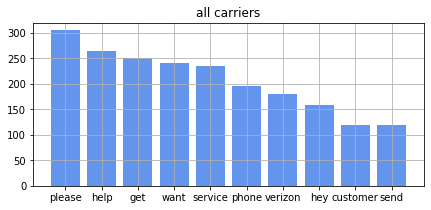

In [2606]:
# распределение слов по всем операторам 

all_text = []
for s in  clean_df['clean_text']:
    for j in s.split():
            all_text.append(j)

total_term_frequency = Counter(all_text)
word_dist = {}
fig, axs = plt.subplots(1, 1, figsize=(7, 3))
axs.grid()
for word, freq in total_term_frequency.most_common(10):
    word_dist[word] = freq
#         print ("{}\t{}".format(word, freq))
    
    plt.bar(word_dist.keys(), word_dist.values(),color = 'cornflowerblue')
    plt.title('all carriers')
    

In [2536]:
# pip install WordCloud

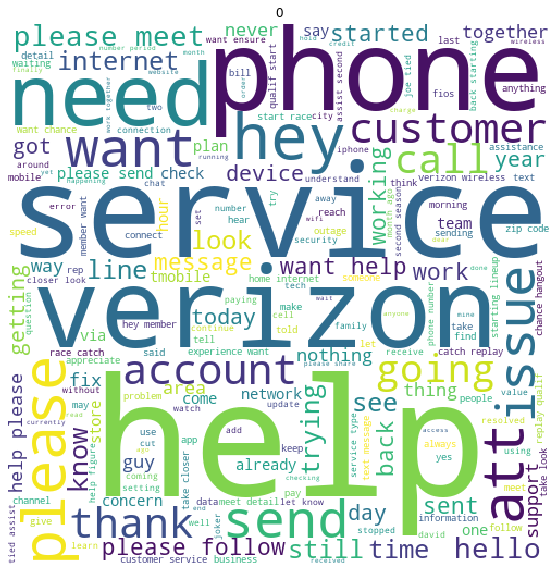

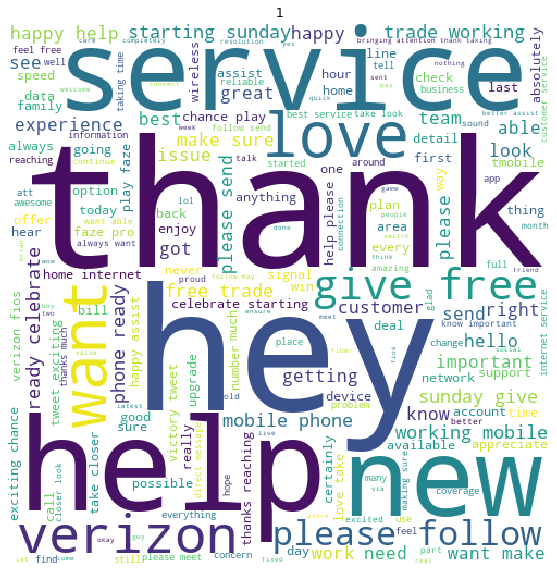

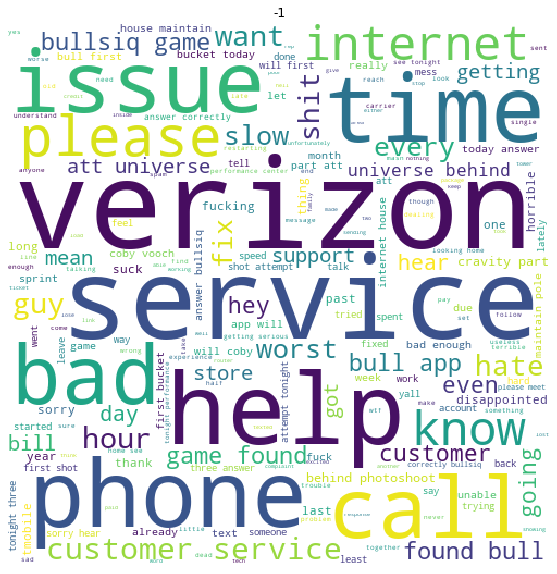

In [2537]:
# word cloud по сентиментам

# https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud) 
    plt.axis("off");

for sense in clean_df['sense_dummy'].unique():
    text = ''
    for t in clean_df[clean_df['sense_dummy'] == sense]['clean_text']:
        text+=t+' '
    wordcloud = WordCloud(width = 500, height = 500, background_color='white', random_state=10).generate(text)
    plot_cloud(wordcloud)
    plt.title(sense)
    


      


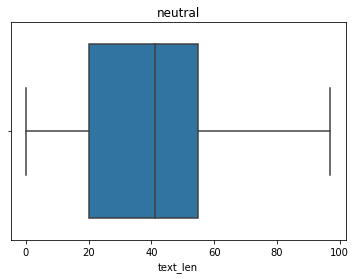

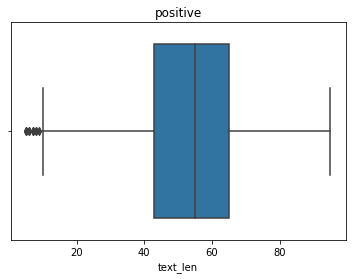

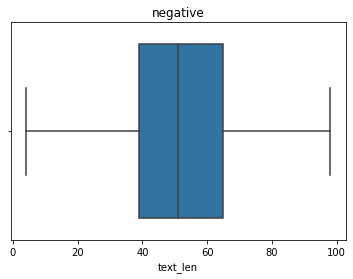

In [2538]:
# боксплоты для каждой категории сентимента

for i in clean_df['sense_dummy'].unique():
    plt.figure()
    if i == 1:
        sns.boxplot(clean_df[clean_df['sense_dummy'] == i]['text_len']).set_title('positive')
    elif i == 0:
        sns.boxplot(clean_df[clean_df['sense_dummy'] == i]['text_len']).set_title('neutral')
    else:
        sns.boxplot(clean_df[clean_df['sense_dummy'] == i]['text_len']).set_title('negative')



### Определи время и как время сообщения распределено по времени

* определи месяц, день недели, день месяца, время дня, часть дня (до обеда, день, вечер - например)

In [2539]:
# добавим 2 столбца : день месяца и часть дня
# clean_df['day_of_month'] = clean_df['date_time'].dt.day
clean_df['part_of_day'] = clean_df['hour'].apply(lambda x: 'night' if 0<x<5 else ('morning' if 6<x<10 else ('day' if 11<x<18 else "evening") ))



In [2540]:
# распределение по месяцам
# for carrier in clean_df['carrier'].unique():
#     fig,axs = plt.subplots(1,1)
#     plt.hist(clean_df[clean_df['carrier'] == carrier]['month'])
#     plt.title(carrier)

In [2541]:
# по дням недели
# for carrier in clean_df['carrier'].unique():
#     fig,axs = plt.subplots(1,1)
#     plt.hist(clean_df[clean_df['carrier'] == carrier]['day'])
#     plt.title(carrier)

(array([583.,   0.,   0., 599.,   0.,   0., 613.,   0.,   0., 648.]),
 array([2. , 2.3, 2.6, 2.9, 3.2, 3.5, 3.8, 4.1, 4.4, 4.7, 5. ]),
 <a list of 10 Patch objects>)

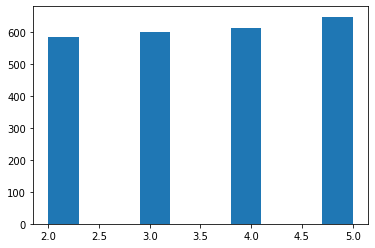

In [2542]:
# по дням недели
fig,axs = plt.subplots(1,1)
plt.hist(clean_df['day'])


In [2543]:
# по числу месяца
# for carrier in clean_df['carrier'].unique():
#     fig,axs = plt.subplots(1,1)
#     plt.hist(clean_df[clean_df['carrier'] == carrier]['day_of_month'])
#     plt.title(carrier)

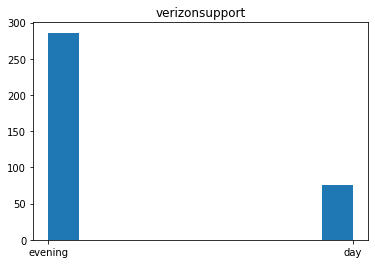

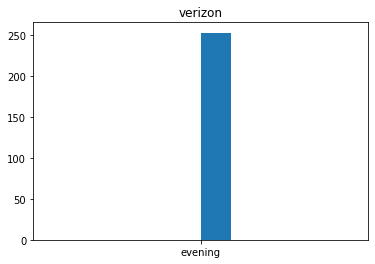

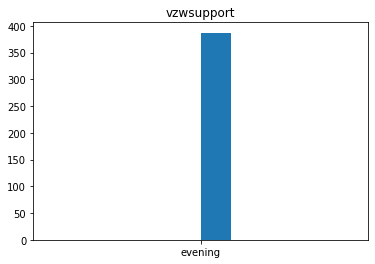

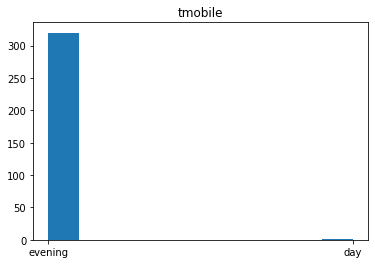

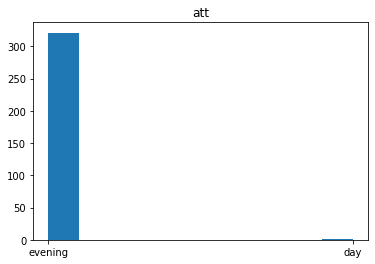

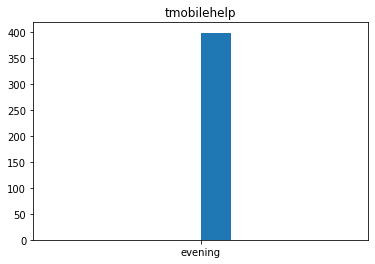

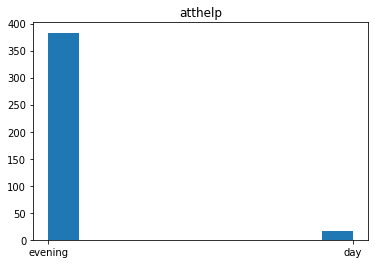

In [2544]:
# по периоду дня
for carrier in clean_df['carrier'].unique():
    fig,axs = plt.subplots(1,1)
    plt.hist(clean_df[clean_df['carrier'] == carrier]['part_of_day'])
    plt.title(carrier)

Text(0.5, 1.0, 'all carriers')

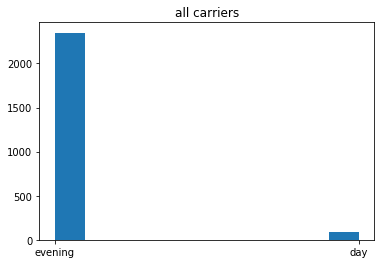

In [2545]:
# по периоду дня
fig,axs = plt.subplots(1,1)
plt.hist(clean_df['part_of_day'])
plt.title('all carriers')

###  Вопрос 5 .какая логика формулы преобразования sin cosine - это перевод в радианы? это потом пойдет в модель

In [2546]:
# преобразование циклических данных (времени)
import numpy as np

seconds_in_day = 24*60*60
clean_df['seconds']= clean_df['date_time'].dt.hour*3600 + clean_df['date_time'].dt.minute*60+clean_df['date_time'].dt.second
clean_df['sin_time'] = np.sin(2*np.pi*clean_df.seconds/seconds_in_day)
clean_df['cos_time'] = np.cos(2*np.pi*clean_df.seconds/seconds_in_day)

In [2547]:
clean_df.head(5)

,screen_name,carrier,location,date_time,text,clean_text,polarity,fact,hour,sense_dummy,text_len,day,part_of_day,seconds,sin_time,cos_time
0,ShieldVoC,verizonsupport,"Stockholm, Sweden",2021-04-14 23:57:51,RT @europabridge1: @VerizonSupport will someon...,someone please explain setting called turned p...,0.000000,1,23,0,54,2,evening,86271,-0.009381,0.999956
1,ShieldVoC,verizon,"Stockholm, Sweden",2021-04-14 23:56:27,RT @halidkalkan: @Verizon trying to charge me ...,trying charge device never solve problem canno,0.000000,1,23,0,46,2,evening,86187,-0.015489,0.999880
2,VerizonSupport,verizonsupport,,2021-04-14 23:43:51,@MushShoe Thanks for confirming. We can assist...,thanks confirming assist plan change well happ...,0.500000,0,23,1,54,2,evening,85431,-0.070409,0.997518
3,MushShoe,verizonsupport,,2021-04-14 23:39:05,"@VerizonSupport Want pricing, my plan ends 3 d...",want pricing plan end day till plan end today ...,0.000000,1,23,0,58,2,evening,85145,-0.091140,0.995838
4,VerizonSupport,verizonsupport,,2021-04-14 23:34:05,@MushShoe Sorry for your trouble. We are also ...,sorry trouble also able provide assistance are...,-0.066667,0,23,-1,64,2,evening,84845,-0.112842,0.993613


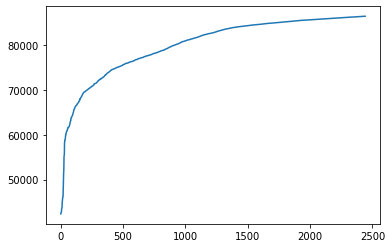

In [2548]:
# создадим датафрейм time исключительно для иллюстрации работы со временем

# clean_df.sin_time.plot(figsize = (16,8))

time = clean_df.sort_values('seconds').reset_index(drop=True)[['seconds','date_time']]

time.seconds.plot()



In [2549]:
time

,seconds,date_time
0,42368,2021-04-16 11:46:08
1,42586,2021-04-16 11:49:46
2,42663,2021-04-16 11:51:03
3,42729,2021-04-16 11:52:09
4,42824,2021-04-16 11:53:44
...,...,...
2438,86395,2021-04-16 23:59:55
2439,86396,2021-04-17 23:59:56
2440,86397,2021-04-14 23:59:57
2441,86398,2021-04-16 23:59:58


In [2550]:
seconds_in_day = 24*60*60

time['sin_time'] = np.sin(2*np.pi*time.seconds/seconds_in_day)
time['cos_time'] = np.cos(2*np.pi*time.seconds/seconds_in_day)

# time.drop('seconds', axis=1, inplace=True)

time.head()

,seconds,date_time,sin_time,cos_time
0,42368,2021-04-16 11:46:08,0.060468,-0.998170
1,42586,2021-04-16 11:49:46,0.044637,-0.999003
2,42663,2021-04-16 11:51:03,0.039042,-0.999238
3,42729,2021-04-16 11:52:09,0.034245,-0.999413
4,42824,2021-04-16 11:53:44,0.027340,-0.999626


In [2551]:
# time.sin_time.plot();


In [2552]:
# time.cos_time.plot();

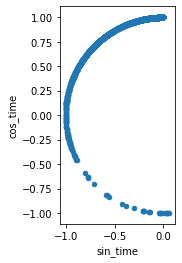

In [2553]:
time.plot.scatter('sin_time','cos_time').set_aspect('equal');

### Сделай распределения и обзор по сентиментному анализу относительно операторов

In [2554]:
# посмотрим процентное распределение сентиментов по операторам

from statsmodels.api import stats
df_conflux = clean_df[['carrier','sense_dummy']]
table1 = stats.Table.from_data(df_conflux)
df_conflux = pd.DataFrame(table1.table_orig)
# for i in df_conflux.columns:
#     print(type(i))
#     print(i)
df_conflux['neg %'] = df_conflux[-1]/(df_conflux[-1]+df_conflux[1]+df_conflux[0])
df_conflux['pos %'] = df_conflux[1]/(df_conflux[-1]+df_conflux[1]+df_conflux[0])
df_conflux['neu %'] = df_conflux[0]/(df_conflux[-1]+df_conflux[1]+df_conflux[0])
df_conflux

sense_dummy,-1,0,1,neg %,pos %,neu %
carrier,,,,,,
att,51,180,91,0.158385,0.282609,0.559006
atthelp,51,226,123,0.127500,0.307500,0.565000
tmobile,40,112,169,0.124611,0.526480,0.348910
tmobilehelp,33,128,238,0.082707,0.596491,0.320802
verizon,40,130,83,0.158103,0.328063,0.513834
verizonsupport,59,167,135,0.163435,0.373961,0.462604
vzwsupport,48,161,178,0.124031,0.459948,0.416021


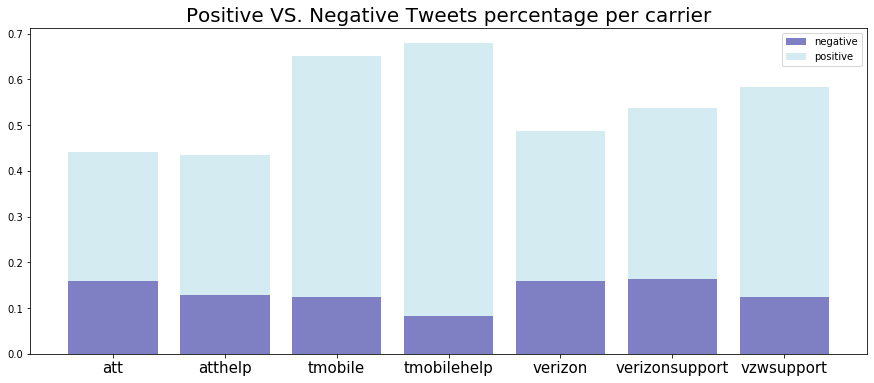

In [2555]:
# посмотрим процентное распределение сентиментов по операторам
plt.figure(figsize=(15,6))
p1 = plt.bar(df_conflux.index, df_conflux['neg %'], color='darkblue',label='negative',alpha=0.5)
p2 = plt.bar(df_conflux.index, df_conflux['pos %'], bottom=df_conflux['neg %'], color='lightblue', label='positive',alpha=0.5)
# p3 = plt.bar(df_conflux.index, df_conflux['neu %'], bottom= df_conflux['pos %'], color='b', label='neutral',alpha=0.5)
plt.legend()
plt.xticks(fontsize=15)
plt.title('Positive VS. Negative Tweets percentage per carrier', fontsize=20)
plt.show()

Text(0, 0.5, 'Tweet Count')

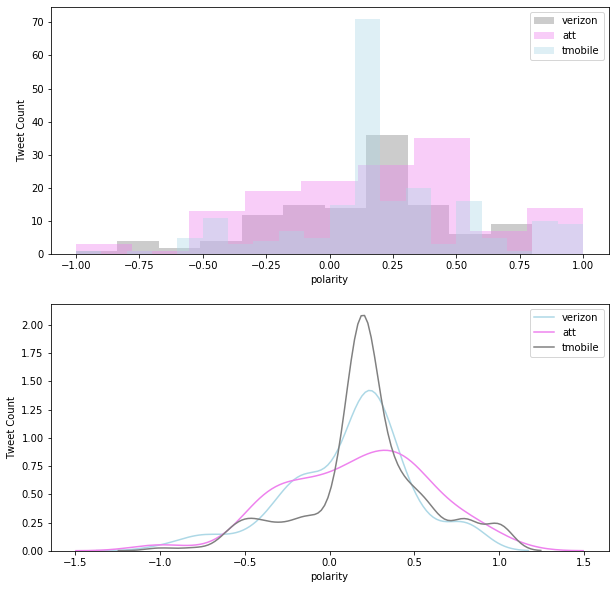

In [2556]:
# распределение polarity по 3 основным операторам

# for carrier in clean_df[clean_df['carrier'].unique():
plt.figure(figsize=(10,10))
plt.subplot(211)
polar_df = clean_df[(clean_df['polarity']>=0.05) | (clean_df['polarity']<=-0.05)]
sns.distplot(polar_df[polar_df['carrier'] == 'verizon']['polarity'], kde=False, hist=True, label="verizon",color = 'grey')
sns.distplot(polar_df[polar_df['carrier'] == 'att']['polarity'], kde=False, hist=True, label="att",color = 'violet')
sns.distplot(polar_df[polar_df['carrier'] == 'tmobile']['polarity'],kde=False, hist=True, label="tmobile",color = 'lightblue')
plt.legend()
plt.ylabel("Tweet Count")

plt.subplot(212)
sns.distplot(polar_df[polar_df['carrier'] == 'verizon']['polarity'], kde=True, hist=False, label="verizon",color = 'lightblue')
sns.distplot(polar_df[polar_df['carrier'] == 'att']['polarity'], kde=True, hist=False, label="att",color = 'violet')
sns.distplot(polar_df[polar_df['carrier'] == 'tmobile']['polarity'],kde=True, hist=False, label="tmobile",color = 'grey')
plt.legend()
plt.ylabel("Tweet Count")

In [2557]:
# clean_df.to_csv('upd_clean_df.csv')


### Создание репрезентативного словаря для негативны и позитивных твитов

In [2558]:
# токенизация очищенного текста

# https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb

from nltk.tokenize import RegexpTokenizer



clean_df["tokens"] = clean_df["clean_text"].apply(tokenizer.tokenize)
all_words = [word for tokens in clean_df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_df["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

17865 words total, with a vocabulary size of 3246
Max sentence length is 16


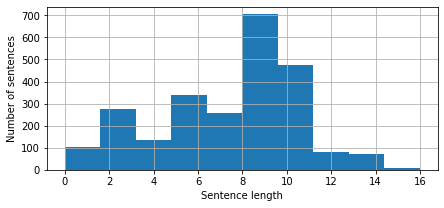

In [2609]:
# уже есть boxplot выше - распределение предложений по длине
fig, axs = plt.subplots(1, 1, figsize=(7, 3))
axs.grid() 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [2560]:
# Bag of words
# https://habr.com/ru/company/Voximplant/blog/446738/

# Import the libraries we need
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# # Step 2. Design the Vocabulary
# # The default token pattern removes tokens of a single character. That's why we don't have the "I" and "s" tokens in the output
# count_vectorizer = CountVectorizer()

# # Step 3. Create the Bag-of-Words Model
# bag_of_words = count_vectorizer.fit_transform(clean_df['clean_text'])

# # Show the Bag-of-Words Model as a pandas DataFrame
# feature_names = count_vectorizer.get_feature_names()
# pd.DataFrame(bag_of_words.toarray(), columns = feature_names)


In [2561]:
# уже было выше - топ-10 слов
# stops =  set(stopwords.words('english')+['com'])
# co = CountVectorizer(stop_words=stops)
# counts = co.fit_transform(clean_df.clean_text)
# pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(10)

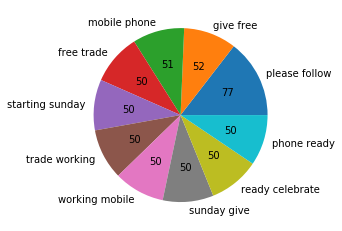

In [2562]:
# топ-10 биграмм
co = CountVectorizer(ngram_range=(2,2),stop_words=stops)
counts = co.fit_transform(clean_df.clean_text)
top_bigrams = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(10)
total = sum(top_bigrams[0].values)
plt.pie(top_bigrams[0],labels = top_bigrams.index,autopct=lambda p: '{:.0f}'.format(p * total / 100))
# plt.legend(loc="upper left")
plt.show()

verizonsupport
Most Common Positive Words :  [('please', 24), ('happy', 23), ('service', 20), ('follow', 19), ('help', 18)]
Most Common Negative Words :  [('verizon', 8), ('service', 7), ('hear', 6), ('get', 6), ('phone', 6)]
verizon
Most Common Positive Words :  [('verizon', 31), ('get', 19), ('ready', 18), ('victory', 18), ('tweet', 18)]
Most Common Negative Words :  [('verizon', 11), ('home', 5), ('like', 4), ('see', 4), ('tonight', 4)]
vzwsupport
Most Common Positive Words :  [('please', 43), ('want', 31), ('follow', 28), ('help', 28), ('get', 21)]
Most Common Negative Words :  [('service', 10), ('customer', 8), ('issue', 8), ('time', 6), ('get', 6)]
tmobile
Most Common Positive Words :  [('give', 56), ('free', 56), ('working', 52), ('phone', 52), ('sunday', 50)]
Most Common Negative Words :  [('service', 7), ('sprint', 4), ('fucking', 4), ('like', 4), ('went', 3)]
att
Most Common Positive Words :  [('win', 12), ('att', 10), ('new', 9), ('top', 7), ('chance', 6)]
Most Common Negati

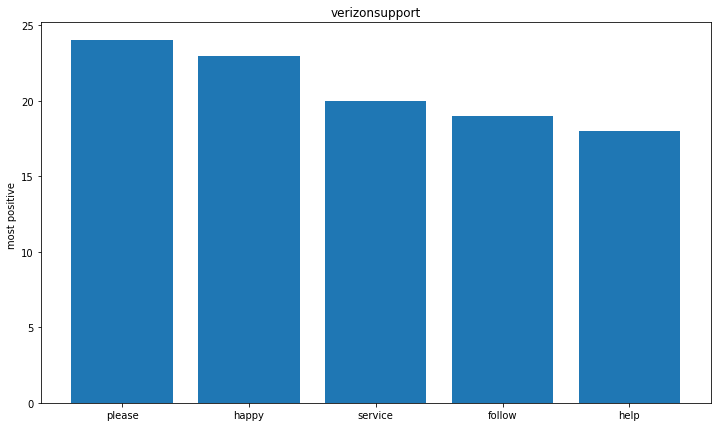

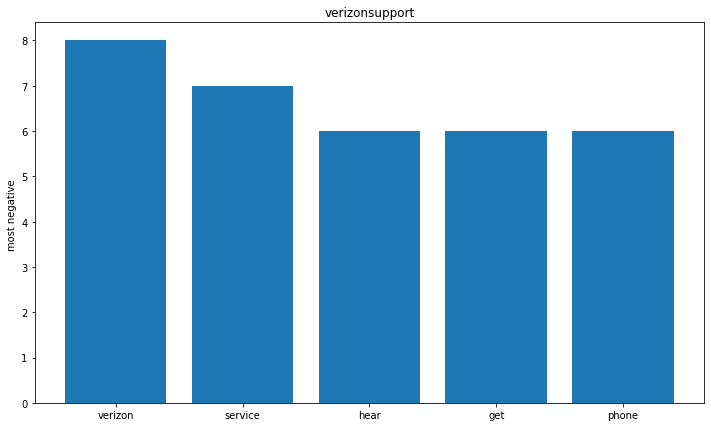

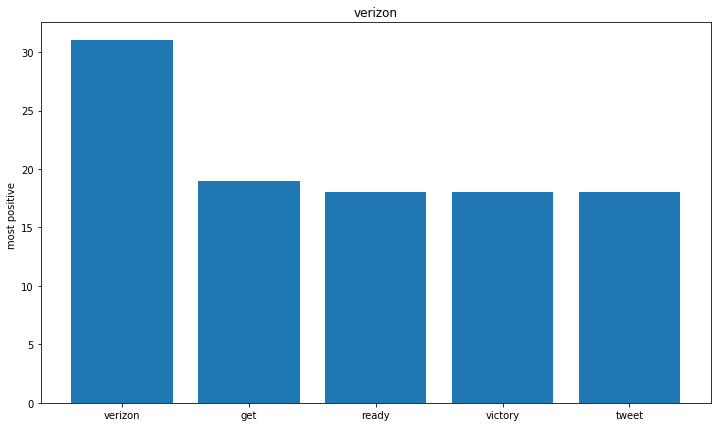

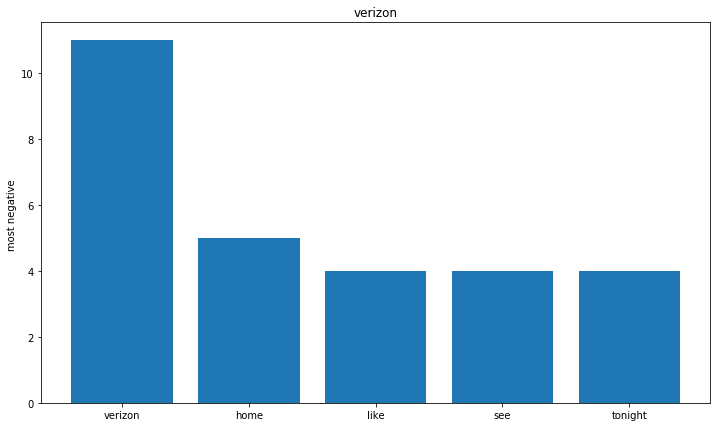

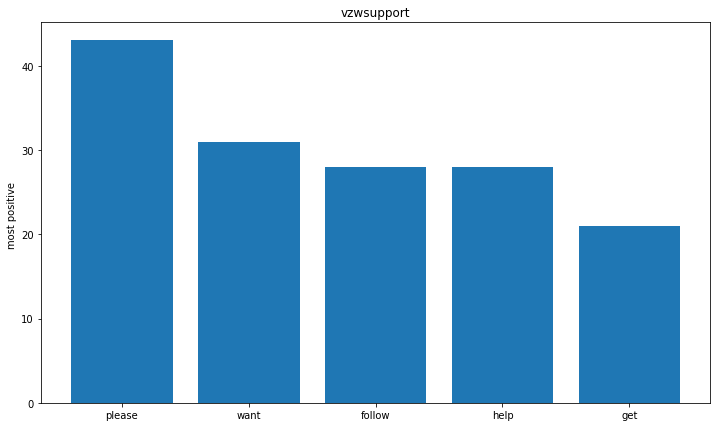

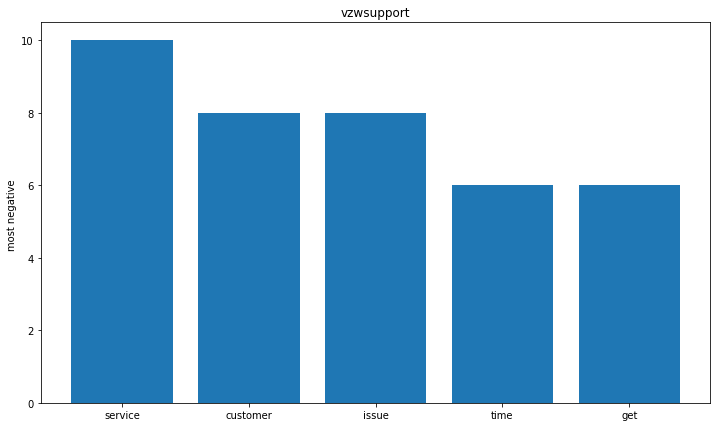

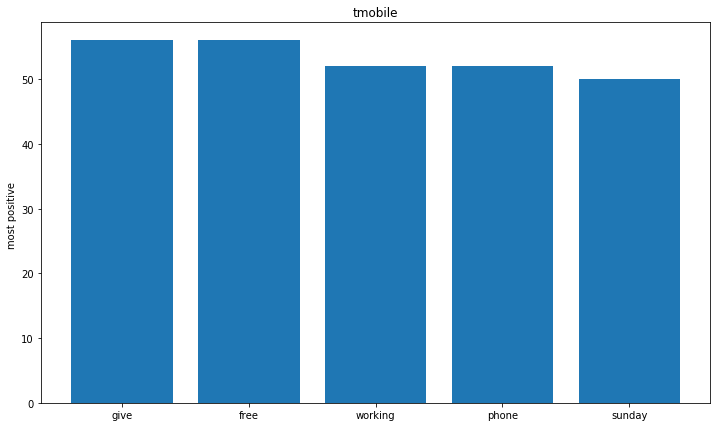

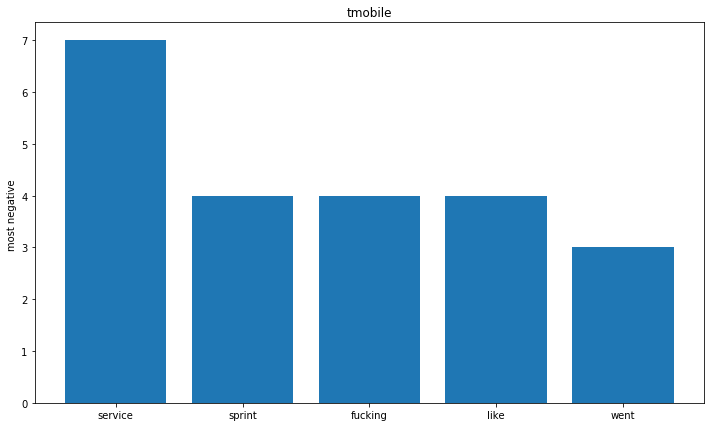

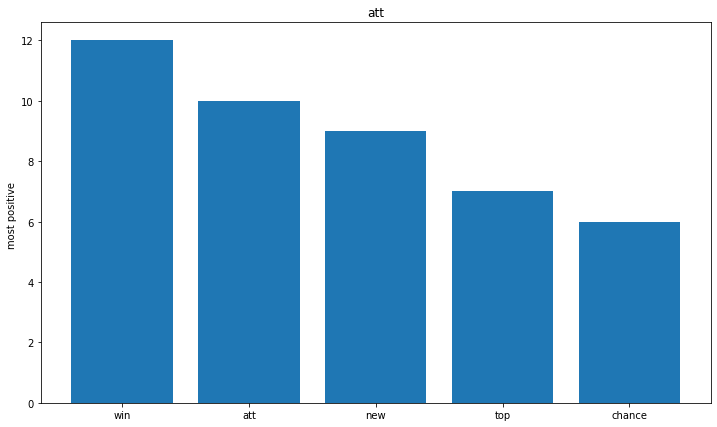

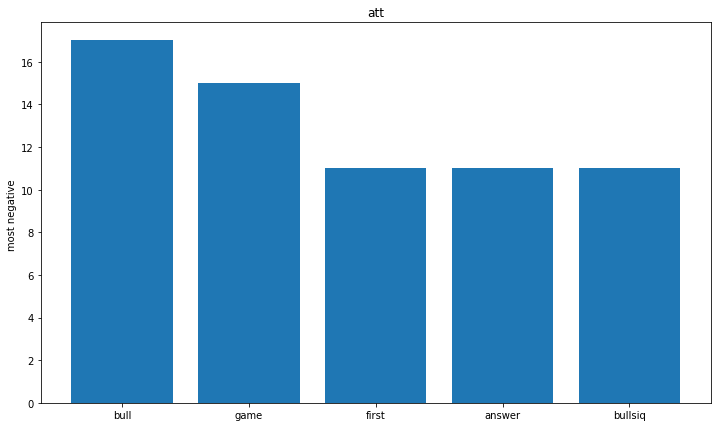

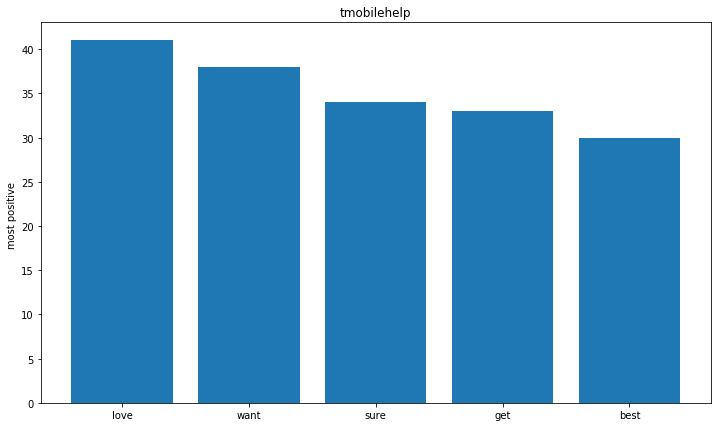

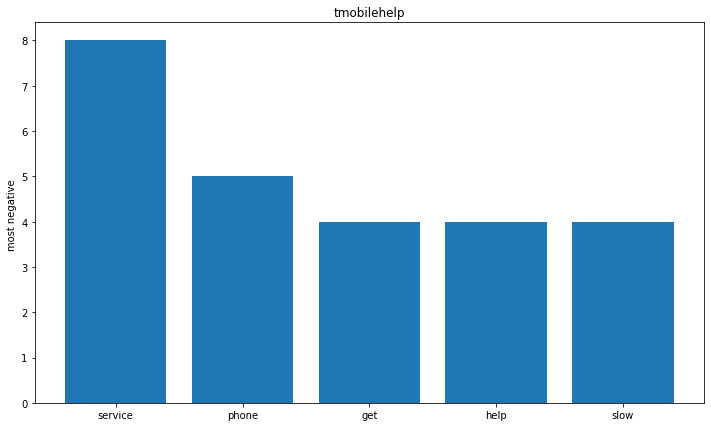

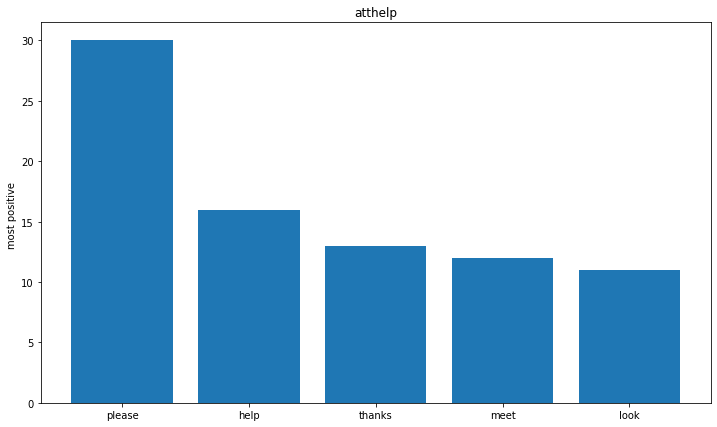

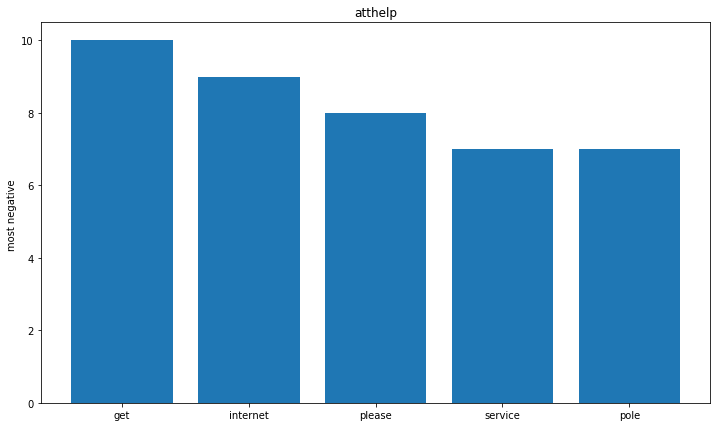

In [2563]:
# самые часто употребляемые слова с разделение по полярности

import nltk
sense_dict = {}
for carrier in clean_df['carrier'].unique():
    print(carrier)
    for sense in clean_df['sense_dummy'].unique():
        text = ''
        for i in clean_df[(clean_df['sense_dummy'] == sense) & (clean_df['carrier'] == carrier)]['clean_text'].values:
    #         print(i)
            text+=i+''
            sense_dict[sense] = text.split()
    freq_dist_positive=nltk.FreqDist(sense_dict[1])
    freq_dist_negative=nltk.FreqDist(sense_dict[-1])
    print("Most Common Positive Words : ",freq_dist_positive.most_common(5))
    print("Most Common Negative Words : ",freq_dist_negative.most_common(5))
    fig, axs = plt.subplots(1, 1, figsize=(12, 7))
    plt.bar([x[0] for x in freq_dist_positive.most_common(5)],[x[1] for x in freq_dist_positive.most_common(5)])
    plt.title(carrier)
    plt.ylabel('most positive ')
    fig, axs = plt.subplots(1, 1, figsize=(12, 7))
    plt.bar([x[0] for x in freq_dist_negative.most_common(5)],[x[1] for x in freq_dist_negative.most_common(5)])
    plt.title(carrier)
    plt.ylabel('most negative ')

Text(0.5, 1.0, 'words')

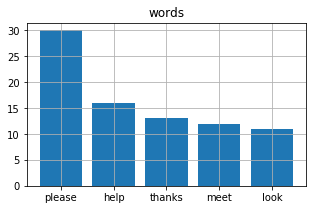

In [2613]:
# топ-5 позитивных слов
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
axs.grid()
plt.bar([x[0] for x in freq_dist_positive.most_common(5)],[x[1] for x in freq_dist_positive.most_common(5)])
plt.title('words')

In [2565]:
# https://github.com/Ashwani018/Amazon-Fine-Food-Reviews/blob/master/Amazon%20Fine%20Food%20Reviews%20Analysis.ipynb

count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(clean_df['clean_text'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2443, 13435)
the number of unique words including both unigrams and bigrams  13435


#### TF-IDF

In [2566]:
# https://github.com/Ashwani018/Amazon-Fine-Food-Reviews/blob/master/Amazon%20Fine%20Food%20Reviews%20Analysis.ipynb

from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(clean_df['clean_text'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2443, 13435)
the number of unique words including both unigrams and bigrams  13435


In [2567]:
features = tf_idf_vect.get_feature_names()
# print("some sample features(unique words in the corpus)",features[4102:4110])

In [2568]:
# топ-25 значимых по tf-idf слов и биграмм

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,10)
top_tfidf
# plt.bar(top_tfidf.feature,top_tfidf['tfidf'])

,feature,tfidf
0,canno,0.314698
1,problem canno,0.314698
2,trying charge,0.302944
3,never solve,0.302944
4,device never,0.302944
5,charge device,0.302944
6,solve,0.293828
7,solve problem,0.293828
8,charge,0.280081
9,problem,0.224930



### Method2: Get representative words by Topic Modeling¶

In [2569]:
# pip install gensim

In [2570]:
# выделение топиков по сентиментам
# https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

# # для метода Topic Modeling понадобятся библиотеки
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LdaMulticore
from gensim.models import TfidfModel
# for carrier in clean_df['carrier'].unique():
#     for sense in clean_df['sense_dummy'].unique():
#         pos = []
#         for i in clean_df[clean_df['sense_dummy'] == sense]['tokens'].values:
#             pos.append(i)

#         dic=Dictionary(pos)
#         bow_corpus = [dic.doc2bow(doc) for doc in pos]
#         lda_model = LdaMulticore(bow_corpus, 
#                                                num_topics = 4, 
#                                                id2word = dic,                                    
#                                                passes = 10,
#                                                workers = 2)
#         print(carrier)
#         print('pos' if sense== 1 else  ('neg' if sense == -1 else 'neu'))
#         print(lda_model.show_topics())


In [2571]:
# попытка визуализации
# import pyLDAvis


# pyLDAvis.enable_notebook()
# vis = pyLDAvis.prepare(lda_model, bow_corpus, dic)
# vis

In [2572]:
# pip install --user gensim

In [2573]:
# pip install delayed

In [2574]:
# общие топики по всему корпусу

# https://dair.ai/Exploratory_Data_Analysis_for_Text_Data/


from sklearn.decomposition import LatentDirichletAllocation, NMF
vectorizer = CountVectorizer(stop_words=stops)
model = vectorizer.fit(clean_df.clean_text)
docs = vectorizer.transform(clean_df.clean_text)
lda = LatentDirichletAllocation(20)
lda.fit(docs)
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([(feature_names[i])
        for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(lda,vectorizer.get_feature_names(),10)

Topic #0: service bill verizon customer pay shit suck know tmobile boy
Topic #1: message thank get great direct hotspot customer att number period
Topic #2: service att hello part change area experience let please issue
Topic #3: get service best customer always provide possible work yes data
Topic #4: hour get say bad internet year old come support house
Topic #5: time start appreciate help thank race catch replay taking qualif
Topic #6: win sent phone never new done think hey help keep
Topic #7: service customer phone check verizon top time week support need
Topic #8: phone working free mobile trade give ready starting sunday celebrate
Topic #9: text back call message following lineup thing att starting thanks
Topic #10: please follow happy assist help way would feel like send
Topic #11: please want help meet detail hey look understand experience see
Topic #12: sure make want send get work help call know important
Topic #13: love please help hey take need would get send look
Topic #1

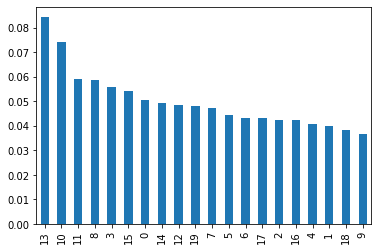

In [2575]:
# распределение по количеству топиков

clean_df['topic']=lda.transform(docs).argmax(axis=1)
clean_df.topic.value_counts(normalize=True).plot.bar()

### вроде не надо - Named entity recognition 

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [2576]:
#  pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0-py3-none-any.whl

In [2577]:
# import spacy

# nlp = spacy.load("en_core_web_sm")

In [2578]:
# создание корпусов по сентиментам

# pos_text = ''
# neg_text = ''
# neu_text = ''
# for i in clean_df['sense_dummy'].unique():
    
#     for text in clean_df[clean_df['sense_dummy'] == i]['clean_text']:
#         if i == -1:
#             neg_text+=text+' '
#         elif i == 0:
#             neu_text+=text+' '
#         else:
#             pos_text+=text+' '
            

In [2579]:
# распределение entity по сенитментам

# def ner(text):
#     doc=nlp(text)
#     return [X.label_ for X in doc.ents]
# for sense in clean_df['sense_dummy'].unique():
#     ent=clean_df[clean_df['sense_dummy'] == sense]['clean_text'].apply(lambda x : ner(x))
#     ent=[x for sub in ent for x in sub]
#     counter=Counter(ent)
#     count=counter.most_common()
#     fig, axs = plt.subplots(1, 1, figsize=(12, 7))
#     x,y=map(list,zip(*count))
# #     print('pos' if sense== 1 else  ('neg' if sense == -1 else 'neu'))
#     sns.barplot(x=y,y=x).set_title('pos' if sense== 1 else  ('neg' if sense == -1 else 'neu'))


https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
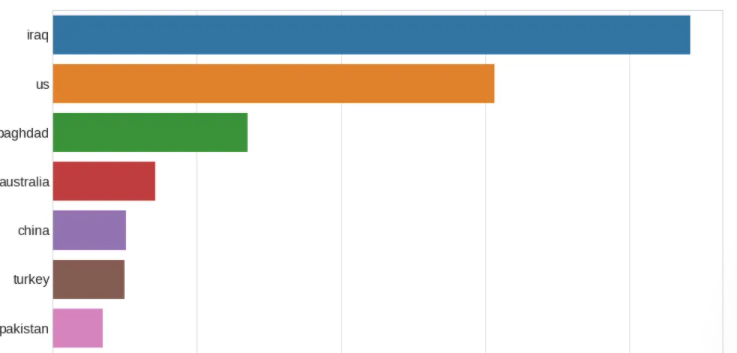

### вроде не надо - Exploration through parts of speach tagging in Python 

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [2580]:
# nltk.download('averaged_perceptron_tagger')

In [2581]:
# распределение по частям предложения

# def pos(text):
#     pos=nltk.pos_tag(word_tokenize(text))
#     pos=list(map(list,zip(*pos)))[1]
#     return pos

# # tags=news['headline_text'].apply(lambda x : pos(x))
# # tags=[x for l in tags for x in l]
# # counter=Counter(tags)

# x,y=list(map(list,zip(*counter.most_common(7))))
# sns.barplot(x=y,y=x)
# for sense in range(-1,2):
# #     print(i)
#     tags = [i[1] for i in nltk.pos_tag(sense_dict[sense])]
#     freq_dist_positive=nltk.FreqDist(tags)
# #     print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
#     counter=Counter(tags)
#     x,y=list(map(list,zip(*counter.most_common(7))))
#     fig, axs = plt.subplots(1, 1, figsize=(12, 7))
#     sns.barplot(x=y,y=x).set_title('pos' if sense== 1 else  ('neg' if sense == -1 else 'neu'))

In [2582]:
# doc = nlp('The greatest comeback stories in 2019')
# displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

### вроде не надо - Exploring through text complexity
https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [2583]:
# pip install textstat

In [2584]:

# from textstat import flesch_reading_ease

# clean_df['clean_text'].apply(lambda x : flesch_reading_ease(x)).hist()

In [2585]:
clean_df[clean_df.location !=''].location.value_counts().head(10)

Bellevue, WA         233
Stockholm, Sweden    140
United States         30
Dallas, TX            19
California, USA       19
Los Angeles, CA       14
Carmichael, CA        11
Houston, TX           10
New York, NY           9
Seattle, WA            9
Name: location, dtype: int64

###  Вопрос ГЛАВНЫЙ - корректно ли выполнен EDA, есть ли комментарии, что добавить и как продолжать? 

### отличия с изначальным вариантом:
    1. убрал emoji analysis
    2. delete n_grams
    3. clean_df.groupby('carrier').agg('mean') - убрал count
    4. убрал подсчет указанных слов 
    5. убрал топ-10 слов
    6. удалил боксплот по длине слов в корпусе
    7. удалил some sample features

### что добавить по EDA:
    1. V -  Mention times for each carrier per day
    2. V -  Q4. Sentiment Analysis for each carrier
    3. V -  b. Overall sentiments polarity for each carrier¶
    4. V -  соотношение сентиментов у каждого оператора
    6. V - распределение по времени по операторам
    8. V - график топ-25 значимых по tf-idf слов и биграмм
    10.V -  Frequent pos/negative words for each carrier
    11.V -  df.location.value_counts()

### Вопросы Артему:
    1. V - Зачем нужен TF-IDF , как его использовать в модели
    2. V - Зачем нужна часть EDA, в которой нет обработки данных
    3. V - для какой модели нужно косинусная трансформация?
    4. V - как добыть 60000 данных
    5. V - напомнить зачем логарифм в IDF

In [2586]:
clean_df.to_csv('part_1.csv')

In [2587]:
clean_df.shape

(2443, 18)